In [1]:
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm as tqdm
from keras.models import load_model
from keras import backend as K
from datetime import datetime

from Dental_Tool.Data_processing import *
from Dental_Tool.Dental_Model import *
from Dental_Tool.Process_results import *
from Dental_Tool.Dataloader import *
from Dental_Tool.KFold_v2 import *

import keras.backend as K 
import matplotlib.pyplot as plt
import numpy as np
import keras
import time

Using TensorFlow backend.


In [2]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=3, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [3]:
# def Unet(input_size=(256, 256, 1), num_classes=3 ):
#     inputs = Input(shape=input_size )

#     ### [First half of the network: downsampling inputs] ###

#     # Entry block
#     x = Conv2D(32, 3, strides=2, padding="same")(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     # Blocks 1, 2, 3 are identical apart from the feature depth.
#     for filters in [64, 128, 256]:
#         x = Activation("relu")(x)
#         x = SeparableConv2D(filters, 3, padding="same")(x)
#         x = BatchNormalization()(x)

#         x = Activation("relu")(x)
#         x = SeparableConv2D(filters, 3, padding="same")(x)
#         x = BatchNormalization()(x)

#         x = MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     ### [Second half of the network: upsampling inputs] ###

#     for filters in [256, 128, 64, 32]:
#         x = Activation("relu")(x)
#         x = Conv2DTranspose(filters, 3, padding="same")(x)
#         x = BatchNormalization()(x)

#         x = Activation("relu")(x)
#         x = Conv2DTranspose(filters, 3, padding="same")(x)
#         x = BatchNormalization()(x)

#         x = UpSampling2D(2)(x)

#         # Project residual
#         residual = UpSampling2D(2)(previous_block_activation)
#         residual = Conv2D(filters, 1, padding="same")(residual)
#         x = add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     # Add a per-pixel classification layer
#     outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

#     # Define the model
#     model = Model(inputs, outputs)
#     return model

In [4]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss

model = Unet()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

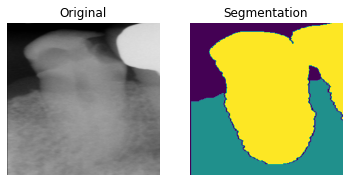

In [7]:
def load_images(path_list, resize, color = False):
        X = []
        for path in tqdm(path_list):
                image = cv2.imread(path, 0)
                if color : 
                        image[ (image != 0) & (image != 128) & (image != 255)  ] = 0
                        image = cv2.resize(image, resize, interpolation = cv2.INTER_NEAREST)
                        
                else : image = cv2.resize(image, resize)
                image = np.expand_dims(image, axis=2)
            
                X.append(image)
        return np.array(X)
    
ori_data = [ i for i in glob.iglob("Dental_Data/PBL/Ori_Seg/Ori/*.png") ]
seg_data = [ i for i in glob.iglob("Dental_Data/PBL/Ori_Seg/Seg/*.png") ]

mapping_data = {  ori: seg for ori, seg in zip(ori_data, seg_data) }

ori_images = load_images(ori_data, (256, 256))
seg_images = load_images(seg_data, (256, 256), color=True)


data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)


image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

train_range = int(len(ori_data) * 0.8)
valid_range = (len(ori_data) - train_range) // 2
test_range  = len(ori_data) - valid_range - train_range

image_datagen.fit(ori_images[0:train_range], augment=True)
mask_datagen.fit(masks[0:train_range], augment=True)

image_generator = image_datagen.flow_from_directory( 'Dental_Data/PBL/Ori_Seg/Ori/Train', class_mode=None, seed=seed)
mask_generator = mask_datagen.flow_from_directory( 'Dental_Data/PBL/Ori_Seg/Seg/Train', class_mode=None, seed=seed)


image_datagen.fit(ori_images[train_range:train_range], augment=True)
mask_datagen.fit(masks[0:train_range], augment=True)

train_generator = zip(image_generator, mask_generator)
_generator = zip(image_generator, mask_generator)







plt.subplot(121)
plt.title("Original")
plt.imshow(ori_images[0], cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title("Segmentation")
plt.imshow(seg_images[0])
plt.axis('off')
plt.show()

In [8]:

history = model.fit(
          ori_images, seg_images,
          validation_data=[ ori_images[ train_range: train_range + valid_range ], seg_images[ train_range: train_range + valid_range]  ],
          batch_size=32, shuffle=True, epochs=100
          )

Train on 118 samples, validate on 14 samples
Epoch 1/100
118/118 [==============================] - 1s 12ms/step - loss: nan - val_loss: nan
Epoch 2/100
 96/118 [=======================>......] - ETA: 0s - loss: nan

KeyboardInterrupt: 

In [ ]:
# preds = model.predict(ori_images[valid_range: valid_range + test_range])

In [ ]:
# preds